In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
import time
from nilearn import datasets
from nilearn.image import load_img, index_img
from nilearn.plotting import plot_epi
from nilearn.maskers import NiftiLabelsMasker
# from PyIF import te_compute as te
from joblib import delayed, Parallel
import pandas as pd
from scipy.stats import zscore
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import glob
from utils.data_loader import DataLoader, fl_to_vox
from utils.plotting import plot_voxels, plot_w_fit
# import seaborn as sns
import time

In [10]:
root_dir = '/scratch/shivansh.seth/adni/preproc'
SCRATCH_DATA_DIR = '/scratch/shivansh.seth/tmp/'
PRINT_TIME_INTERVAL = 20
if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)

In [15]:
dloader = DataLoader(root_dir)
subjects_list = dloader.subjects_list
subjects_list

['002_S_0295',
 '002_S_0413',
 '002_S_1261',
 '002_S_1280',
 '002_S_4213',
 '002_S_4225',
 '002_S_4262',
 '002_S_4264',
 '002_S_4270',
 '002_S_5018',
 '006_S_0498',
 '006_S_0731',
 '006_S_4150',
 '006_S_4153',
 '006_S_4192',
 '006_S_4357',
 '006_S_4449',
 '006_S_4485',
 '006_S_4546',
 '006_S_4867',
 '010_S_4345',
 '010_S_4442',
 '010_S_5163',
 '012_S_4026',
 '012_S_4545',
 '012_S_4643',
 '013_S_4579',
 '013_S_4580',
 '013_S_4616',
 '013_S_4731',
 '013_S_5071',
 '018_S_4257',
 '018_S_4313',
 '018_S_4349',
 '018_S_4399',
 '018_S_4400',
 '018_S_4696',
 '018_S_4733',
 '018_S_5074',
 '018_S_5240',
 '019_S_4252',
 '019_S_4367',
 '019_S_4477',
 '019_S_4549',
 '019_S_4835',
 '019_S_5012',
 '019_S_5019',
 '031_S_4021',
 '031_S_4024',
 '031_S_4032',
 '031_S_4218',
 '031_S_4474',
 '031_S_4496',
 '053_S_4578',
 '053_S_5070',
 '053_S_5208',
 '100_S_0069',
 '100_S_1286',
 '100_S_4469',
 '100_S_4511',
 '100_S_5106',
 '100_S_5246',
 '129_S_0778',
 '129_S_4369',
 '129_S_4371',
 '129_S_4396',
 '129_S_44

In [4]:
def autocorr(x):
    xp = x - np.mean(x)
    n = len(x)
    f = np.fft.fft(xp, n*2)
    acf = np.real(np.fft.ifft(f * np.conjugate(f))[:n])
    # acf /= (4*np.var(x))
    acf /= acf[0]
    return acf

def st_exp_decay(t, tau, A, beta, B=0):
    return A * np.exp(-np.power(t/tau, beta)) + B

def exp_decay(t, tau, A, B=0):
    return A * np.exp(-t/tau) + B

def plot_w_fit(data, tau, A, beta, B):
    plt.plot(autocorr(data))
    t = np.arange(len(data))
#     tau, A, B = roi_rts[roi_idx, sub_idx, 0:3]
    plt.plot(st_exp_decay(t, tau, A, beta, B), label=f'St exp tau={tau:.2f}, beta={beta: .2f}')
    return plt

In [5]:
def relaxation_time(x, t, t_max=None):
    if t_max is None:
        t_max = len(t) // 2
    p0 = [t[t_max], 1]
    bounds = [[0, 0], [np.inf, np.inf]]
    B = np.mean(x[50:])
    A = 1 - B
    func = lambda t, tau, beta: st_exp_decay(t, tau, beta=beta, A=A, B=B)
    popt, pcov = curve_fit(func, t[:t_max], x[:t_max], p0=p0, bounds=bounds)
    se = np.sqrt(np.mean(np.diag(pcov)))
    t = np.array(t)
#     print(t.shape)
    res = x - func(t, *popt)
    rmse = np.sqrt(np.mean(res**2))
    tau = popt[0]
    beta = popt[1]
    return tau, beta, A, B, rmse, se

def relaxation_time_og(x, t, t_max=None):
    if t_max is None:
        t_max = len(t) // 2
    p0 = [t[t_max]]
    bounds = [[0], [np.inf]]
    B = np.mean(x[50:])
    A = 1 - B
    func = lambda t, tau: exp_decay(t, tau, A=A, B=B)
    popt, pcov = curve_fit(func, t[:t_max], x[:t_max], p0=p0, bounds=bounds)
    se = np.sqrt(np.mean(np.diag(pcov)))
    t = np.array(t)
#     print(t.shape)
    res = x - func(t, *popt)
    rmse = np.sqrt(np.mean(res**2))
    tau = popt[0]
    return tau, A, B, rmse, se

In [7]:
rts_res_dir = '/home/shivansh.seth/phase_diagram_analysis/rts_results_both'
rts_fl = []
for sub in dloader.subjects_list:
    for j in os.listdir(rts_res_dir):
        if sub in j:
            rts_fl.append(os.path.join('rts_results_both', j))

subject_list = dloader.subjects_list

rts_results= np.memmap(
        os.path.join(SCRATCH_DATA_DIR, 'roi_rts.dat'), 
        dtype='float32', 
        mode='w+', 
        shape=(len(dloader.subjects_list), *dloader.get_func(0).shape[:-1], 7)
    )

for idx, i in enumerate(rts_fl):
    rts = np.load(i)
    rts_results[idx] = rts
    del rts

In [33]:
og_shape_rts = rts_results.shape
rts_results_flat = rts_results.reshape(og_shape_rts[0], -1, 5)
rts_results_flat[rts_results_flat==np.inf] = np.nan
og_shape = og_shape_rts[1: -1]


In [34]:
rts_rmse = rts_results_flat[:, :, 3]
rts_se = rts_results_flat[:, :, 4]
rts = rts_results_flat[:, :, 0]

In [35]:
cn_roi_rts = np.array([ rts[i] for i in range(rts.shape[0]) if dloader.diag[i] == 0 ])
cn_subs = [dloader.subjects_list[i] for i in range(rts.shape[0]) if dloader.diag[i] == 0]
ad_roi_rts = np.array([ rts[i] for i in range(rts.shape[0]) if dloader.diag[i] == 1 ])
ad_subs = [dloader.subjects_list[i] for i in range(rts.shape[0]) if dloader.diag[i] == 1]

In [36]:
ad_typ = dloader.get_func(ad_subs[20]).get_fdata().reshape(-1, 140)
cn_typ = dloader.get_func(cn_subs[40]).get_fdata().reshape(-1, 140)

In [37]:
ad_typ.shape

(228939, 140)

In [38]:
betas_ad = []
taus_ad = []
def get_beta(ts):
    signal = autocorr(ts)
    try: 
        tau, beta, A, B, rmse, se = relaxation_time(signal, list(range(len(signal))))
    except:
        print(f'Fit failed for tau={tau_og}')
        return None
    return tau, beta

res = Parallel(n_jobs=10)(delayed(get_beta)(ad_typ[i]) for i in range(ad_typ.shape[0]))
res = np.array(res)

# for i in range(ad_typ.shape[0]):
#     st_time = time.time()
#     ts = ad_typ[i]
#     signal = autocorr(ts)
#     try: 
#         tau, beta, A, B, rmse, se = relaxation_time(signal, list(range(len(signal))))
#     except:
#         print(f'Fit failed for tau={tau_og}')
#         continue
# #     t = np.arange(len(ad_typ[i]))
# #     tau_i, A_i, B_i,_,_ = relaxation_time_og(signal, list(range(len(signal))))
#     betas_ad.append(beta)
#     taus_ad.append(tau)
#     print(f'time taken {time.time() - st_time}')
#     break
#     if i%10000 == 0:
#         plt = plot_w_fit(ts, tau, A, beta, B)
#         plt.plot(exp_decay(t, tau_i, A_i, B_i), label=f'Exp decay tau={tau_i}')
#         plt.title(f'$\\tau = {tau_i: .2f}$')
#         plt.legend()
#         plt.show()

KeyboardInterrupt: 

In [ ]:
res_cn = Parallel(n_jobs=10)(delayed(get_beta)(cn_typ[i]) for i in range(cn_typ.shape[0]))
res_cn = np.array(res)

In [ ]:
betas_cn = []
taus_cn = []
for i in range(cn_typ.shape[0]):
    signal = autocorr(cn_typ[i])
    ts = cn_typ[i]
    try: 
        tau, beta, A, B, rmse, se = relaxation_time(signal, list(range(len(signal))))
    except:
        print(f'Fit failed for tau={tau_og}')
        continue
    t = np.arange(len(ad_typ[i]))
    tau_i, A_i, B_i,_,_ = relaxation_time_og(signal, list(range(len(signal))))
    betas_cn.append(beta)
    taus_cn.append(tau)
    if i%10000 == 0:
        plt = plot_w_fit(ts, tau, A, beta, B)
        plt.plot(exp_decay(t, tau_i, A_i, B_i), label=f'Exp decay tau={tau}')
        plt.title(f'$\\tau = {tau_i: .2f}$')
        plt.legend()
        plt.show()

In [ ]:
bins = range(1)
indices = {}
for i, _ in enumerate(bins):
    idx = np.where((rts>i) & (rts < i+1))
    try:
        sub_idx = idx[0][0]
        roi_idx = idx[1][0]
    except:
        print(f'No timeseries found for tau>{i} and <{i+1}')
        print(idx)
        continue
    tau_og = rts[sub_idx, roi_idx]
    roi_vox = fl_to_vox(roi_idx)
    fimg = dloader.get_func(subject_list[sub_idx])
    ts = fimg.dataobj[roi_vox]
    signal = autocorr(ts)
    try: 
        tau, beta, A, B, rmse, se = relaxation_time(signal[signal>0], list(range(len(signal[signal>0]))))
    except:
        print(f'Fit failed for tau={tau_og}')
        continue
    t = np.arange(len(ts)//2)
#     plt = plot_w_fit(ts, tau, A, beta, B)A
    plt.plot(np.log(signal[signal>0]))
    st_exp = st_exp_decay(t, tau, A, beta, B)
    print(f'B_stretched: {B}, B: {B_i}')
    plt.plot(np.log(st_exp-B), label=f'St exp tau={tau:.2f}, beta={beta: .2f}')
    tau_i, A_i, B_i, _, _ = relaxation_time_og(signal[signal>0], list(range(len(signal[signal>0]))))
    plt.plot(np.log(exp_decay(t, tau_i, A_i, B_i)-B_i), label=f'Exp decay tau={tau_i:.2f}')
    plt.title(f'$\\tau = {tau_i: .2f}$')
    plt.legend()
    plt.show()
    print(f'New fit: tau={tau} beta={beta}')

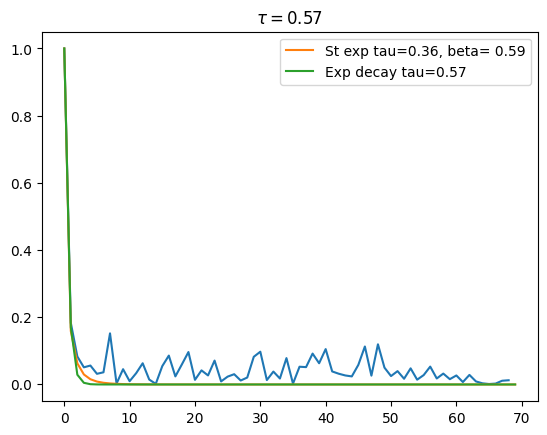

New fit: tau=0.35620852392021324 beta=0.5895981881247228


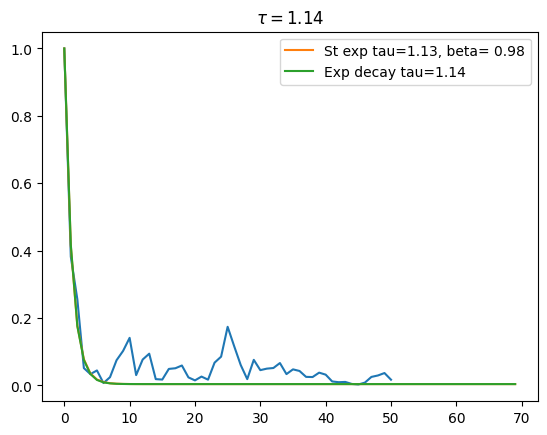

New fit: tau=1.1283293664935374 beta=0.9783320667313444


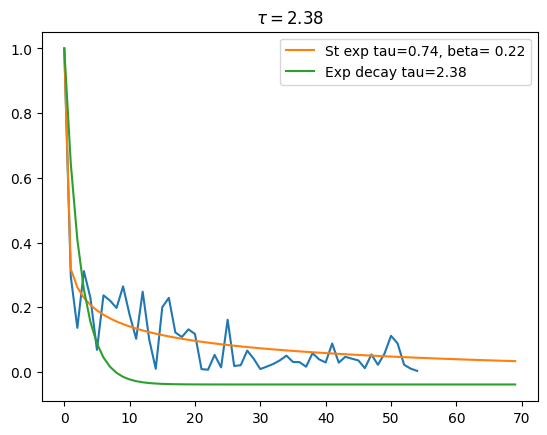

New fit: tau=0.7384942557268509 beta=0.2162258774239456


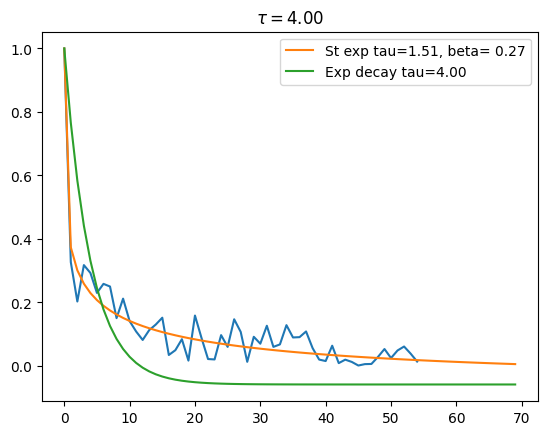

New fit: tau=1.5054643579154496 beta=0.269465334451296


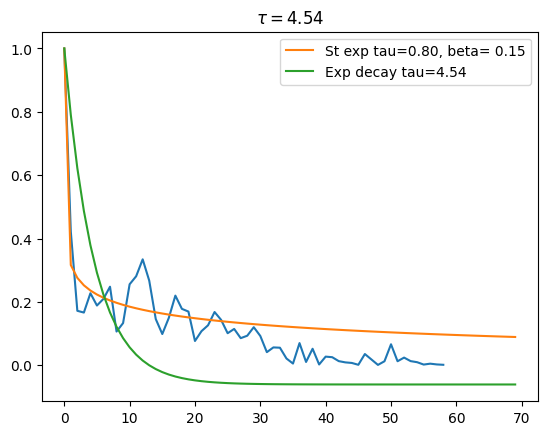

New fit: tau=0.7996590662737488 beta=0.1505741369044487


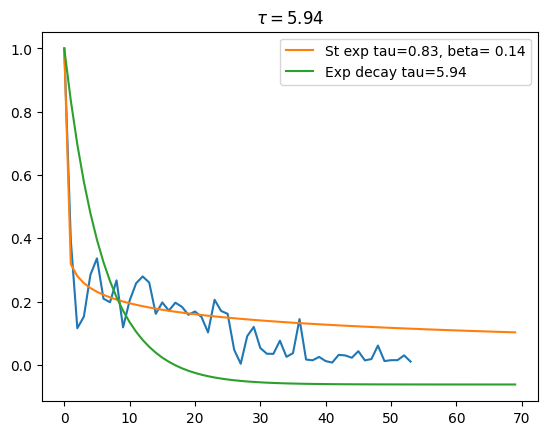

New fit: tau=0.8292521977041987 beta=0.14077639060465857


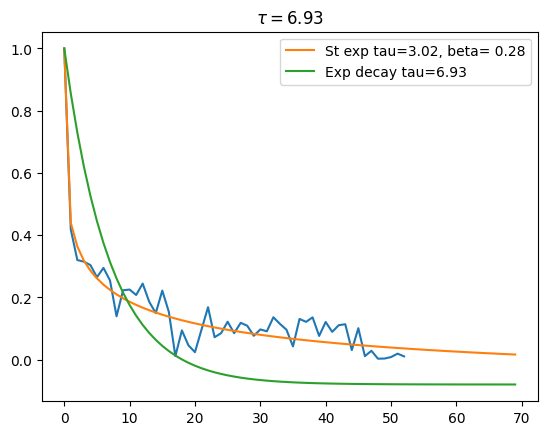

New fit: tau=3.0214394096204025 beta=0.2821658295044199


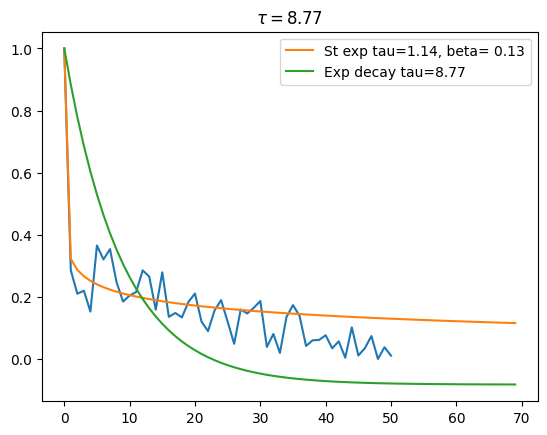

New fit: tau=1.1436100348518496 beta=0.12918897102535581


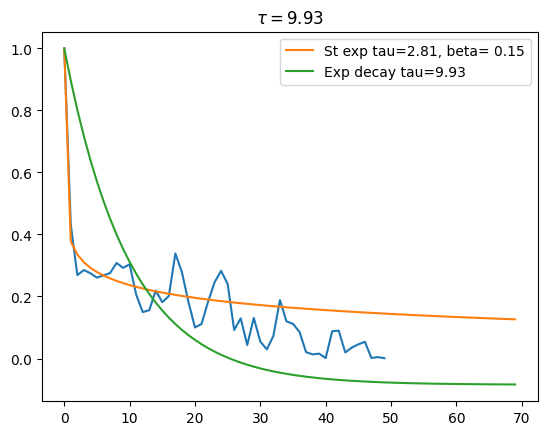

New fit: tau=2.8128083975721387 beta=0.15389696138223072


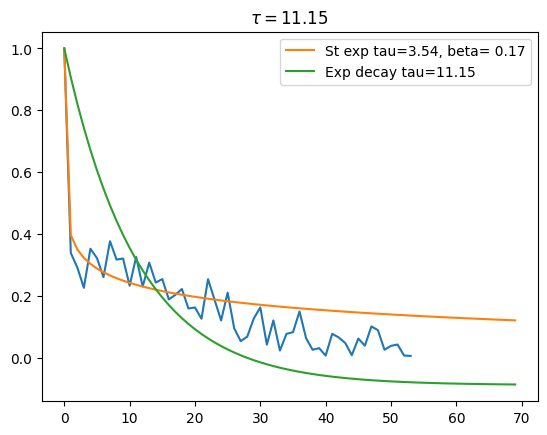

New fit: tau=3.5402294732272854 beta=0.16815894680468235


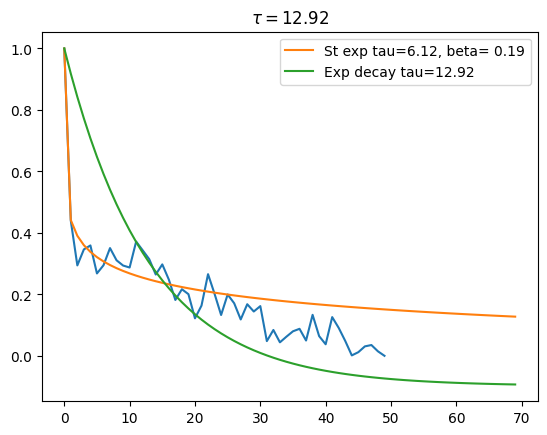

New fit: tau=6.124018549432608 beta=0.1891959981610618


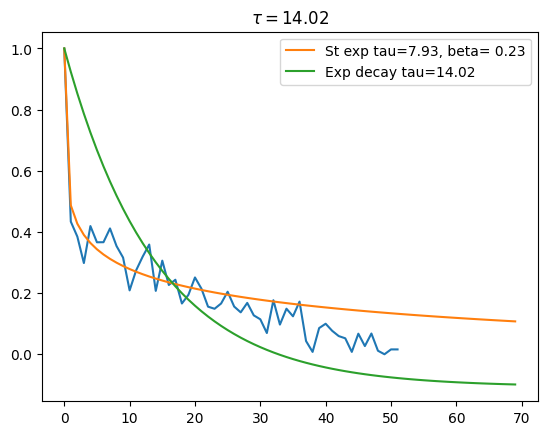

New fit: tau=7.929536825275003 beta=0.2290684695120435


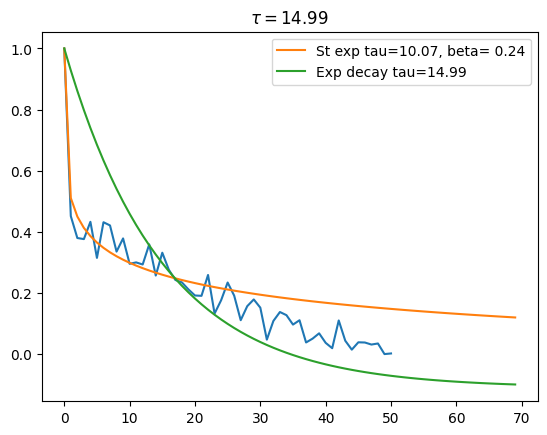

New fit: tau=10.072862916710802 beta=0.235350741261936


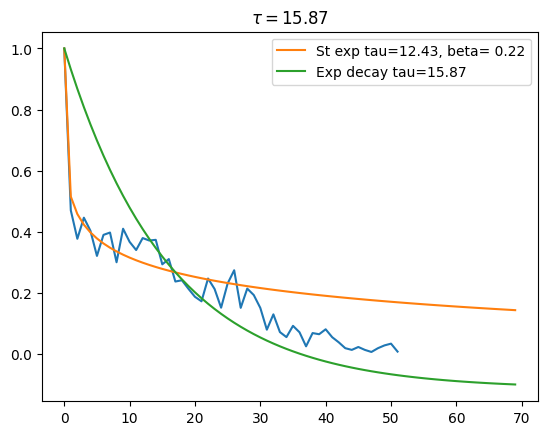

New fit: tau=12.425168216266163 beta=0.22240814085032368


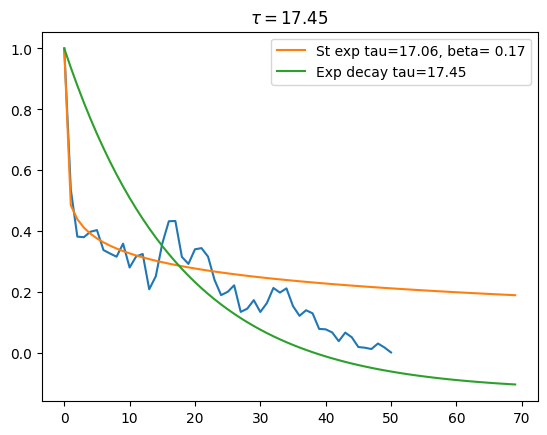

New fit: tau=17.063960876239378 beta=0.1731228398225651


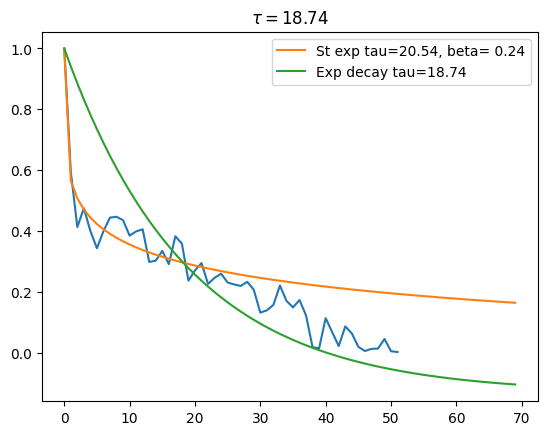

New fit: tau=20.539411730687267 beta=0.2406109363664665


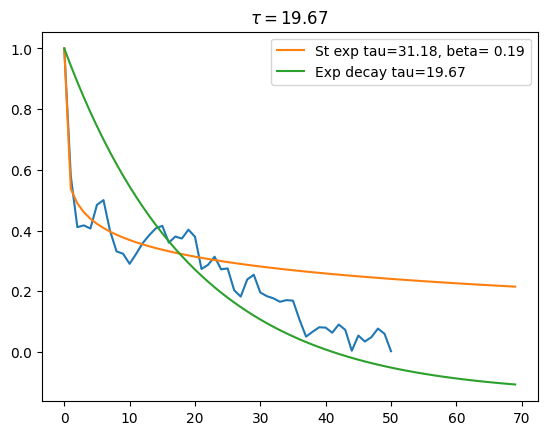

New fit: tau=31.177304158140053 beta=0.1905297802096283


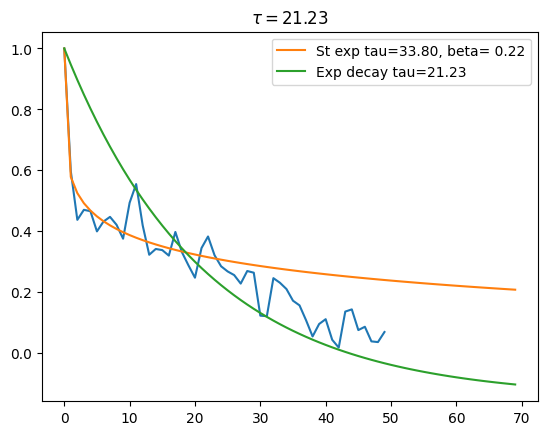

New fit: tau=33.80209722623165 beta=0.2217431421486868


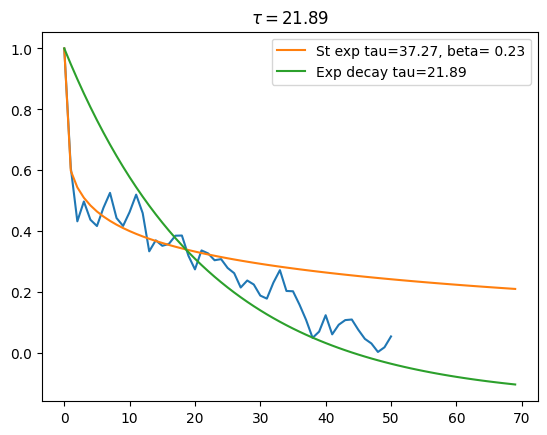

New fit: tau=37.27237938826221 beta=0.23444857283970386


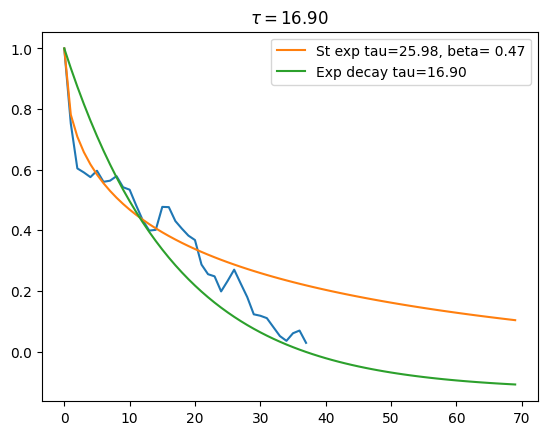

New fit: tau=25.9831096449994 beta=0.4713418726486209


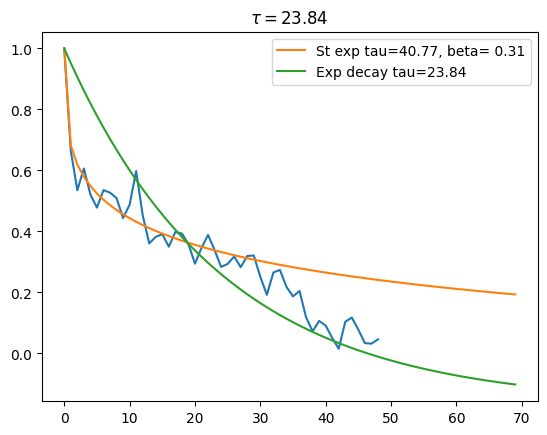

New fit: tau=40.76740641800722 beta=0.3082851995722531


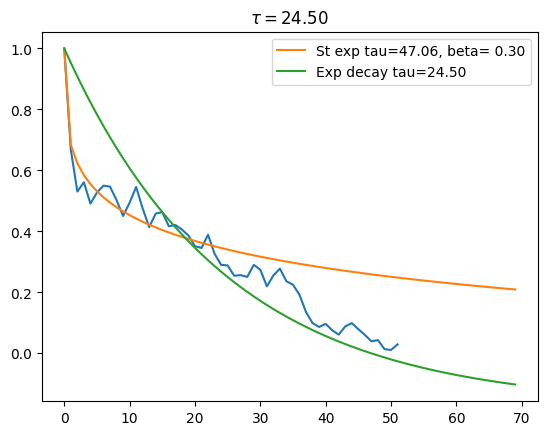

New fit: tau=47.05938137331958 beta=0.30039305614117423


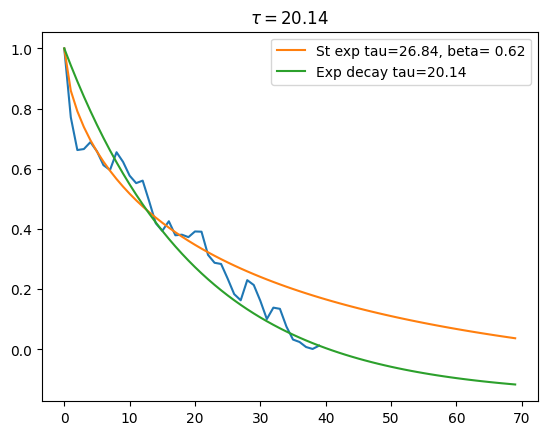

New fit: tau=26.835164408683465 beta=0.6212213353851216


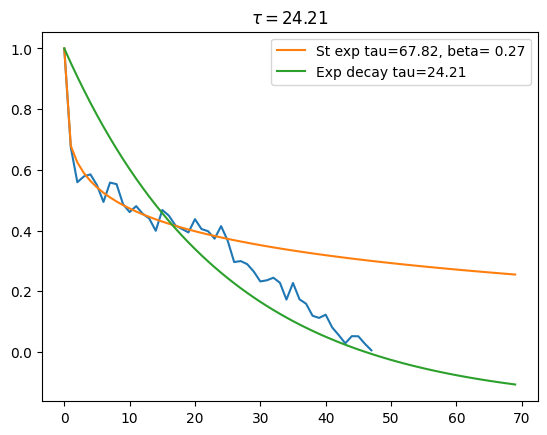

New fit: tau=67.81984490364711 beta=0.27094508593631156


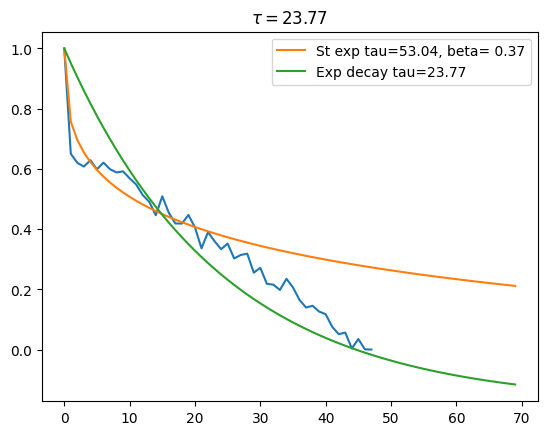

New fit: tau=53.03761514467659 beta=0.3695432864930315


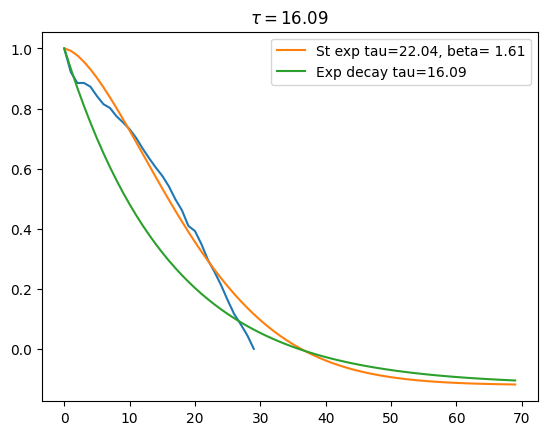

New fit: tau=22.036118009896704 beta=1.6130648134590218


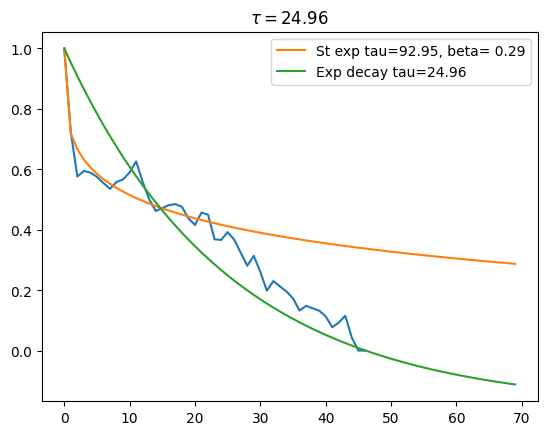

New fit: tau=92.94975409599385 beta=0.28884209765615587


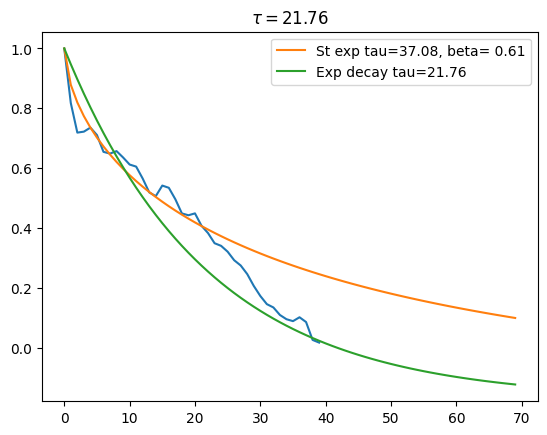

New fit: tau=37.08261503999037 beta=0.6125515936649822


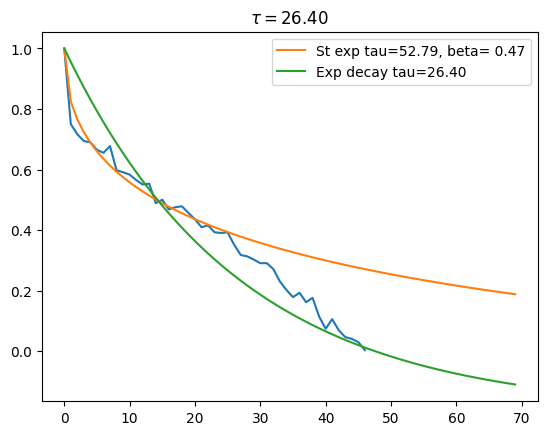

New fit: tau=52.78862428331708 beta=0.46568254752339555


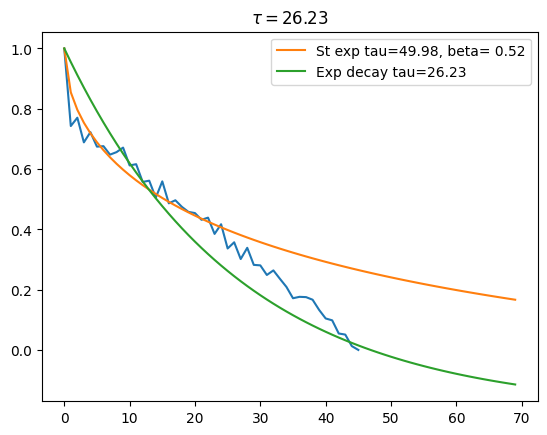

New fit: tau=49.98295159001631 beta=0.5233416768345498


In [43]:
bins = range(30)
indices = {}
for i, _ in enumerate(bins):
    idx = np.where((rts>i) & (rts < i+1))
    try:
        sub_idx = idx[0][0]
        roi_idx = idx[1][0]
    except:
        print(f'No timeseries found for tau>{i} and <{i+1}')
        print(idx)
        continue
    tau_og = rts[sub_idx, roi_idx]
    roi_vox = fl_to_vox(roi_idx)
    fimg = dloader.get_func(subject_list[sub_idx])
    ts = fimg.dataobj[roi_vox]
    signal = autocorr(ts)
    try: 
        tau, beta, A, B, rmse, se = relaxation_time(signal, list(range(len(signal))))
    except:
        print(f'Fit failed for tau={tau_og}')
        continue
    t = np.arange(len(ts)//2)
#     plt = plot_w_fit(ts, tau, A, beta, B)A
    plt.plot(signal[signal>0])
    st_exp = st_exp_decay(t, tau, A, beta, B)
    plt.plot(st_exp, label=f'St exp tau={tau:.2f}, beta={beta: .2f}')
    tau_i, A_i, B_i, _, _ = relaxation_time_og(signal, list(range(len(signal))))
#     print(f'B_stretched: {B}, B: {B_i}')
    plt.plot(exp_decay(t, tau_i, A_i, B_i), label=f'Exp decay tau={tau_i:.2f}')
    plt.title(f'$\\tau = {tau_i: .2f}$')
    plt.legend()
    plt.show()
    print(f'New fit: tau={tau} beta={beta}')